# IFN-646 Project: Images Classification of Breast Cancer

## Description

In this file, we will perform how we run the classifiers to classify which case considered as **BENIGN** or **MALIGNANT**.

### Data Cleaning and Wrangling

In this section of code, we will do the Data cleaning and Wrangling including do the stratified sampling.

In [118]:
#Import Library needed
import pandas as pd
import os
import re
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
tf.keras.backend.clear_session()
pd.set_option('display.max_colwidth', -1)

In [53]:
#Function to set the subject ID for calc and mass dataset
def generate_full_mask(name, file):
    df_full = pd.read_csv(file)
    df_full[['assessment', 'abnormality id']] = df_full[['assessment', 'abnormality id']].astype(str)
    df_full['Subject ID'] = name+df_full['patient_id']+'_'+df_full['left or right breast']+'_'+df_full['image view']
    df_mask = pd.read_csv(file)
    df_mask[['assessment', 'abnormality id']] = df_mask[['assessment', 'abnormality id']].astype(str)
    df_mask['Subject ID'] = name+df_mask['patient_id']+'_'+df_mask['left or right breast']+'_'+df_mask['image view']+'_'+df_mask['abnormality id']
    df_full = df_full.drop_duplicates(subset=['Subject ID'], keep='first')
    df_mask = df_mask.drop_duplicates(subset=['Subject ID'], keep='first')
    return df_full, df_mask

#Function to get the pathfile
def get_name(directory):

    names = []

    for root, dirs, files in os.walk(directory):
        for filename in files:
            _, ext = os.path.splitext(filename)
            if ext in ['.png']:
                names.append(os.path.join(root, filename))

    return names

def merge_path(data1, data2, tpe):
    #Select necessary column to match with metadata from calc and mass dataset
    data1 = data1.iloc[:,[8,9,14]]
    data2 = data2.iloc[:,[8,9,14]]
    merge1 = pd.merge(data1, result, on='Subject ID', how='inner')
    merge2 = pd.merge(data2, result, on='Subject ID', how='inner')
    #Only select the mask file, which start with 1-2.dcm (Thus keep the last)
    merge2 = merge2.drop_duplicates(subset=['Subject ID'], keep='last')
    #Re-index the dataframe
    merge1 = merge1.reindex(columns=['Subject ID','assessment','pathology','Match','Pathfile'])
    merge2 = merge2.reindex(columns=['Subject ID','assessment','pathology','Match','Pathfile'])
    #Change the Benign Without Callback to Benign
    merge1['pathology'] = merge1['pathology'].replace(['BENIGN_WITHOUT_CALLBACK'],'BENIGN')
    merge2['pathology'] = merge2['pathology'].replace(['BENIGN_WITHOUT_CALLBACK'],'BENIGN')
    #Rename the pathfile into mask for mask dataset before merge
    merge2 = merge2.rename(columns={"Pathfile" : "Mask"})
    #Rename the subject ID for mask dataset before mergex
    merge2['Subject ID'] = merge2['Subject ID'].str[:-2]
    #merge two dataframe into one with pathfile for mask and raw image
    merge = pd.merge(merge1, merge2, on=['Subject ID','assessment','pathology'], how='inner')
    #keep neccessary column
    merge = merge.iloc[:,[0,1,2,4,6]]
    #make new column to help sampling
    merge['sampling'] = np.where(merge['assessment'] != '4', 1, 2)
    merge['type'] = tpe
    return merge

In [54]:
#Initiate dataset
calc_train_full, calc_train_mask = generate_full_mask('Calc-Training_','calc_case_description_train_set.csv')
calc_test_full, calc_test_mask = generate_full_mask('Calc-Test_', 'calc_case_description_test_set.csv')
mass_train_full, mass_train_mask = generate_full_mask('Mass-Training_','mass_case_description_train_set.csv')
mass_test_full, mass_test_mask = generate_full_mask('Mass-Test_','mass_case_description_test_set.csv')
metadata = pd.read_csv('metadata.csv')

In [55]:
#Initiate the variable to get the pathfile for each images
names = get_name('CBIS-DDSM')
#Make it into dataframe
names = pd.DataFrame(names,columns=['Pathfile'])
#Make the Match Column to match with File Location in metadata
names['Match'] = names['Pathfile'].str[:-12]
#Make a new column called Match for joining the metadata with pathfile from names
metadata['Match'] = metadata['File Location'].str[2:]
#Drop unnecessary column from metadata
metadata = metadata.iloc[:,[4,17]]
#Merge the new PNG pathfile to metadata
result = pd.merge(metadata, names, on='Match', how='inner')

In [56]:
#Pathfile for each dataset
calc_train = merge_path(calc_train_full,calc_train_mask, 'calc')
calc_test = merge_path(calc_test_full,calc_test_mask, 'calc')
mass_train = merge_path(mass_train_full,mass_train_mask, 'mass')
mass_test = merge_path(mass_test_full,mass_test_mask, 'mass')

In [57]:
# concat calc and mass dataset
training = pd.concat([calc_train, mass_train])
test = pd.concat([calc_test, mass_test])

## Data Split

In [58]:
def split(data, stratify, size):
    rs = 10
    # target/input split
    Y = data.loc[:,['pathology']]
    X = data.drop(['pathology'], axis=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size, 
                                                        stratify=data[stratify], 
                                                        random_state=rs)
    return X_test, Y_test

In [59]:
#create the assess 4 dataframe
assess_4 = training.loc[training['sampling'] == 2]
#sampling the data (50% from sampling data will be based on this data, so the proportion is 0.1*0.5)
sample_4, target_4 = split(assess_4, ['pathology','type'], 0.05)
#create the assess 1-3 and 4-6
assess_r = training.loc[training['sampling'] == 1]
#sampling
sample_r, target_r = split(assess_r, ['pathology','type'], 0.05)
#merge sampling
training_sample = pd.concat([sample_r, sample_4])
training_target = pd.concat([target_r, target_4])
training_target['encode'] = np.where(training_target['pathology'] != 'BENIGN', 0, 1)

In [60]:
#Sampling the test dataset
assess_4 = test.loc[test['sampling'] == 2]
#sampling the data
sample_4, target_4 = split(assess_4, ['pathology','type'], 0.08)
#create the assess 1-3 and 4-6
assess_r = test.loc[test['sampling'] == 1]
#sampling
sample_r, target_r = split(assess_r, ['pathology','type'], 0.08)
#merge sampling
test_sample = pd.concat([sample_r, sample_4])
test_target = pd.concat([target_r, target_4])
test_target['encode'] = np.where(test_target['pathology'] != 'BENIGN', 0, 1)

## Classifier - ResNet

In [61]:
#Function to load image
def load_image(path, target_size, scale_factor):     
    im = Image.open(path)
    w, h = im.size
    im = im.resize((target_size, target_size))
    im=np.asarray(im) / scale_factor
    return np.asarray(im)

In [62]:
training_full_img = []
training_mask_img = []
test_full_img = []
test_mask_img = []

training_full = training_sample['Pathfile']
training_mask = training_sample['Mask']
test_full = test_sample['Pathfile']
test_mask = test_sample['Mask']

#iteration to read the image
for path in training_full:
    load = load_image(path,256,255.0)
    training_full_img.append(load)
for path in training_mask:
    load = load_image(path,256,255.0)
    training_mask_img.append(load)
for path in test_full:
    load = load_image(path,256,255.0)
    test_full_img.append(load)
for path in test_mask:
    load = load_image(path,256,255.0)
    test_mask_img.append(load)

In [63]:
training_full_img = np.reshape(training_full_img, (len(training_full_img),256,256,1))
training_mask_img = np.reshape(training_mask_img, (len(training_full_img),256,256,1))
test_full_img = np.reshape(test_full_img, (len(test_full_img),256,256,1))
test_mask_img = np.reshape(test_mask_img, (len(test_mask_img),256,256,1))

(57, 256, 256, 1)

In [80]:
train_pathology = np.asarray(training_target['encode'])
test_pathology = np.asarray(test_target['encode'])

In [88]:
train_pathology = keras.utils.to_categorical(train_pathology, 2)
test_pathology = keras.utils.to_categorical(test_pathology, 2)

In [66]:
#Show image to check if it's load without error
#fig = plt.figure(figsize=[10, 10])
#for i in range(20):
    #ax = fig.add_subplot(4, 5, i + 1)
    #ax.imshow(training_full_img[i,:,:,:])

In [108]:
#TRY WITH SIMPLE NETWORK
inputs = keras.Input(shape=(256, 256, 1 ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(5,5), activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = layers.Flatten()(x)
x1 = layers.Dense(64, activation='relu')(x)
pathology = layers.Dense(2, name='pathology_out')(x1)

model_cnn = keras.Model(inputs=inputs, outputs=[pathology], name='simple_classifier')
model_cnn.summary()

Model: "simple_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 252, 252, 8)       208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 16)      3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 32)        12832     
_________________________________________________________________
flatten (Flatten)            (None, 103968)      

In [113]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='binary_crossentropy', 
                  metrics=[tf.keras.metrics.Accuracy()])

In [114]:
history = model_cnn.fit(training_full_img,[train_pathology],
                    batch_size=64,
                    epochs=20,
                    validation_data=(test_full_img,[test_pathology]))

Epoch 1/20
3/3 [==============================] - 3s 873ms/step - loss: 6.2953 - accuracy: 0.0000e+00 - val_loss: 5.9196 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 3s 801ms/step - loss: 6.6388 - accuracy: 0.0000e+00 - val_loss: 5.9196 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 3s 856ms/step - loss: 6.3092 - accuracy: 0.0000e+00 - val_loss: 5.9196 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 3s 828ms/step - loss: 6.2493 - accuracy: 0.0000e+00 - val_loss: 5.9196 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 3s 913ms/step - loss: 6.3092 - accuracy: 0.0000e+00 - val_loss: 5.9196 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 3s 794ms/step - loss: 6.2493 - accuracy: 0.0000e+00 - val_loss: 5.9196 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 3s 813ms/step - loss: 6.3092 - accuracy: 0.0000e+00 - val_loss

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

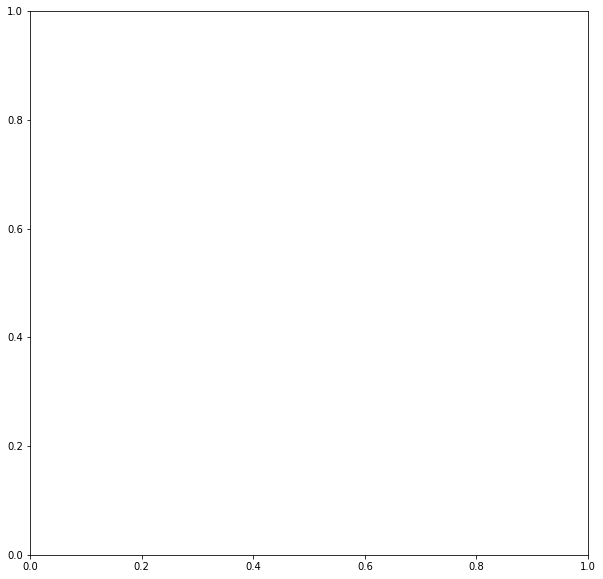

In [119]:
def eval_models(model, x_test, y_test, history):

    predictions_label = model.predict(x_test)
    
    indexes = tf.argmax(predictions_label, axis=1)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels= classify)
    c.plot(ax = ax)
    ax.set_title(' confusion matrix')
    
    fig = plt.figure(figsize=[15, 15])
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(history.history['loss'], label = 'Overall Loss')
    ax.plot(history.history['_out_loss'], label = ' loss')
    ax.legend()
    ax.set_title('Training Loss')

    ax = fig.add_subplot(3, 1, 2)
    ax.plot(history.history['val_loss'], label = 'Overall Loss')
    ax.plot(history.history['val_'+'_out_loss'], label = ' loss')
    ax.legend()
    ax.set_title('Validation Loss')
    
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(history.history['_out_accuracy'], label = ' training accuracy')
    ax.plot(history.history['val_'+'_out_accuracy'], label = ' test accuracy')
    ax.legend()
    ax.set_title('Accuracy')

eval_models(model_cnn, test_full_img, test_pathology, history)